# Trial ID classifier

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn import svm
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 32364       ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf=1            ## value of resampling
session_now = 1
BINS = 70
FR_limit = 12
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_unsup = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_unsupervised/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/decoding/'

In [6]:

print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0
for trial in [1,6,11,16]:

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        params.append(r2_params)
    resample_params = np.array(params)
        
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)

    behaviour_list.append(resample_beh1)
    parameters_list.append(resample_params)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]


    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                            '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

     ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

    activity_list.append(resample_neural_activity_mean)

    day = day + 1
        

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR


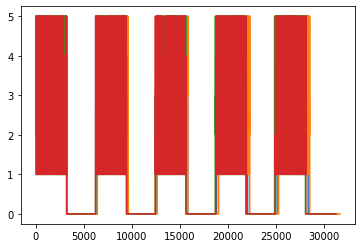

In [149]:
### create trail labels
trial_id_vector = []
order_id_vector = []
for day in [0,1,2,3]:
    ###create trial id vector
    Xpre_all = activity_list[day].T
    trial_id = np.zeros((Xpre_all.shape[0],1))
    order_id = np.arange(0,Xpre_all.shape[0])
    ##trial to trail train and test decoder
    for trial in range(5):
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])
        trial_id[time0:time1]=trial+1        
        #block = int(np.floor((time1-time0)/10)*10)
        #shuffle = np.random.permutation(np.arange(time0,time0+block).reshape(int(block/10), 10)).reshape(block).astype(int)
        #order_id[time0:time0+block]= shuffle
    index_track = np.where(trial_id>0)[0]
    order_track = order_id[index_track]
    size =(np.floor(order_track.shape[0]/10)*10).astype(int)
    shuffle = np.random.permutation(order_track[0:size].reshape(int(size/10), 10)).reshape(size).astype(int)
    order_id[index_track[0:size]] = shuffle
 
    trial_id_vector.append(trial_id[order_id])
    order_id_vector.append(order_id)
    plt.plot(trial_id_vector[day])
    


In [153]:
kfold_number = 5
kf = KFold(n_splits=kfold_number)
gnb = GaussianNB()

test_input_kfold_list = []
test_output_kfold_list = []
gnb_training_list = []

for day in [0,1,2,3]:
    
    ### prepare neural data
    Xpre_all = activity_list[day].T
    firing_rate = np.mean(Xpre_all,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    Xpre_all = Xpre_all[:,selected_cells]
        
    index_track = np.where(trial_id_vector[day]>0)[0]
    order = order_id_vector[day][index_track]
    print(order)
    X = Xpre_all[order,:]
    #print(X.shape)
    trial_id = trial_id_vector[day][order]
    #select training and testing datasets
    test_input_kfold = []
    test_output_kfold = []
    gnb_training = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test= X[train_index], X[test_index]
        y_train, y_test = trial_id[train_index], trial_id[test_index]
                
        #save testing data for this kfold
        test_input_kfold.append(X_test)
        test_output_kfold.append(y_test)
                
        #train cca+classifier
        gnb_training.append(GaussianNB().fit(X_train,y_train))
    
    test_input_kfold_list.append(test_input_kfold)
    test_output_kfold_list.append(test_output_kfold)
    gnb_training_list.append(gnb_training)

[27732 27733 27734 ... 28363 28364 28365]
[26391 26392 26393 ... 26690 28521 28522]
[21332 21333 21334 ... 28075 28076 28077]
[ 8696  8697  8698 ... 28122 28123 28124]


In [146]:
score_matrix_gnb_list = []

for day in range(4):
    score_matrix_gnb = np.zeros((5,))
    for i in range(kfold_number):
        classifier = gnb_training_list[day][i]
        fitting = classifier.predict(test_input_kfold_list[day][i])
        score_gnb = classifier.score(test_input_kfold_list[day][i],test_output_kfold_list[day][i])
        #print(score_gnb)
        probability = classifier.predict_proba(test_input_kfold_list[day][i])
        score_matrix_gnb[i]=score_gnb
    print(score_matrix_gnb)
        

[0.18088737 0.19422898 0.19484952 0.21967111 0.19863439]
[0.20043573 0.2054155  0.17403487 0.19676214 0.20080946]
[0.21522146 0.20929507 0.20430443 0.19900187 0.20405616]
[0.1734375  0.17875    0.17724289 0.19506096 0.21256643]


In [145]:
print(probability)

[[1.29655047e-02 1.33790773e-01 5.17168438e-01 6.47500167e-03
  3.29600283e-01]
 [2.44981066e-02 3.12939975e-01 4.36607052e-01 8.39020015e-03
  2.17564666e-01]
 [1.04183718e-06 3.14815369e-04 9.91720231e-01 1.83165180e-03
  6.13226014e-03]
 ...
 [5.84542910e-02 8.88167239e-01 1.48423535e-02 7.14880022e-03
  3.13873162e-02]
 [5.75219098e-02 8.36961852e-01 3.97941214e-02 1.09873482e-02
  5.47347685e-02]
 [3.67043493e-02 8.74420198e-01 3.64123354e-02 5.79832984e-03
  4.66647879e-02]]
